In [1]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from scipy.constants import c, h, k, epsilon_0, mu_0

In [2]:
design = designs.DesignPlanar()

In [3]:
design.overwrite_enabled = True
design.chips.main
design.chips.main.size.size_x = '3mm'
design.chips.main.size.size_y = '3mm'
gui = MetalGUI(design)

In [4]:
from IPython.display import Image, display
def guiCapture(name='shot'):
    gui.figure.savefig(name + '.png')
    _disp_ops = dict(width=500)
    display(Image('shot.png', **_disp_ops))

In [5]:
design.variables['cpw_width'] = '15um'
design.variables['cpw_gap'] = '9um'

# Device Design
---

In [6]:
from qiskit_metal.qlibrary.tlines import meandered, straight_path
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee
from qiskit_metal.qlibrary.qubits.transmon_pocket_6 import TransmonPocket6

In [32]:
"""
Readout & Ports
50 Ohm CPW
"""
port_1_options = Dict(pos_x='-1mm',pos_y='2mm',orientation='0') # readout 
port_2_options = Dict(pos_x='1mm',pos_y='2mm',orientation='180')
#port_3_options = Dict(pos_x='-1mm',pos_y='0mm',orientation='0') # control

port_1_termination = LaunchpadWirebondCoupled(design,'Port1_Termination',options=port_1_options)
port_2_termination = LaunchpadWirebondCoupled(design,'Port2_Termination',options=port_2_options)
#port_3_termination = LaunchpadWirebondCoupled(design,'Port3_Termination',options=port_3_options)

readout_line_options = Dict( pin_inputs=Dict(
    start_pin=Dict(component='Port1_Termination', pin='tie'),
    end_pin=Dict(component='Port2_Termination', pin='tie')))

ReadoutLine=straight_path.RouteStraight(design,'readoutTransmissionLine',options=readout_line_options)


"""
Pocket Transmon
g
"""
# TransmonPocket6.get_template_options(design)
transmon_options =  dict(   
        pos_x='-0.5mm',pos_y='1.25mm',orientation='-90', 
        connection_pads=dict(readout = dict(loc_W=0, loc_H=+1, cpw_extend='10um'),
                             #control = dict(loc_W=+1, loc_H=-1, cpw_extend='10um')
                            ),
        gds_cell_name='FakeJunction_01')

q1 = TransmonPocket6(design, 'Q1', options=transmon_options)

coupled_line_tee_options=Dict(pos_x='+50um', pos_y='2mm', mirror=True,down_length='50um',
                              prime_width=design.variables['cpw_width'], second_width=design.variables['cpw_width'] )

CouplingTee=CoupledLineTee(design, "CouplingTee",options=coupled_line_tee_options)

# control_line_options = Dict( pin_inputs=Dict(
#     start_pin=Dict(component='Q1', pin='control'),
#     end_pin=Dict(component='Port3_Termination', pin='tie')),total_length = '1mm',)

# ControlLine=meandered.RouteMeander(design,'controlline',options=control_line_options)

"""
Resonator
Q
f0
"""
qbit_tee_options=Dict(  pos_x='-50um', pos_y='0.5mm',mirror=False,down_length='150um',
                        prime_width=design.variables['cpw_width'], 
                        second_width=design.variables['cpw_width'])
QbitCouplingTee=CoupledLineTee(design, "QbitCouplingTee",options=qbit_tee_options)

qbit_tee_options=Dict(  pos_x='-0.0mm', pos_y='1.25mm',mirror=False,t_length='200um',
                        prime_width=design.variables['cpw_width'], orientation='-90', 
                        second_width=design.variables['cpw_width'])
QbitCouplingTee=LineTee(design, "QbitCouplingTee",options=qbit_tee_options)

resonator_termination_options= Dict(pos_x='1.0mm',pos_y='0.8mm',orientation='-90')
ground_termination = ShortToGround(design,"resonatorGround",options=resonator_termination_options)

meanderA_options = Dict(
    pin_inputs = Dict(  start_pin=Dict(component='CouplingTee', pin='second_end'),
                        end_pin=Dict(component='resonatorGround', pin='short')), 
                        lead = Dict(start_straight='800um',end_straight='10um'),
                        total_length = '5mm', fillet = '99.00um', width=design.variables['cpw_width'])
MeanderA = meandered.RouteMeander(design,'meanderA', options=meanderA_options)

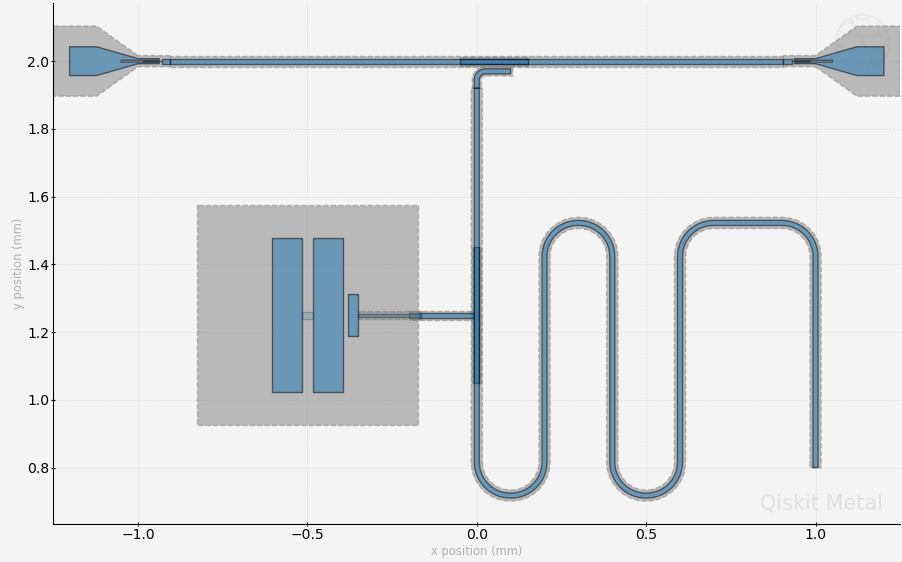

In [33]:
gui.rebuild(); gui.autoscale()
guiCapture()

In [ ]:
line_tee.LineTee.get_template_options(design)

In [ ]:
gui.main_window.close()

# Simulation
---

In [ ]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")